# Machine Learning with FastAI - Lesson 3
#### Bruno Martins Valério Bomfim, 211039297

## 1. Purpose

In this article, we are going to train different image-classifiers models for glass cups and wine glasses, in order to introduce fundamental concepts of curve fitting, optimization, and performance.

## 2. Collecting data

#### 2.1. Importing all required libraries (supposing there're already installed):

In [22]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
import timm

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### 2.2. Downloading images within images folder.

In [5]:
searches = 'glass cup','empty wine glass'
path = Path('images')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo', 100))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'glass cup photo'
Searching for 'empty wine glass photo'


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### 2.3. Cleaning failed images

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

## 3. Training the model

Ok, so let's put the images into a datablock (that contains a training set and a validation set).

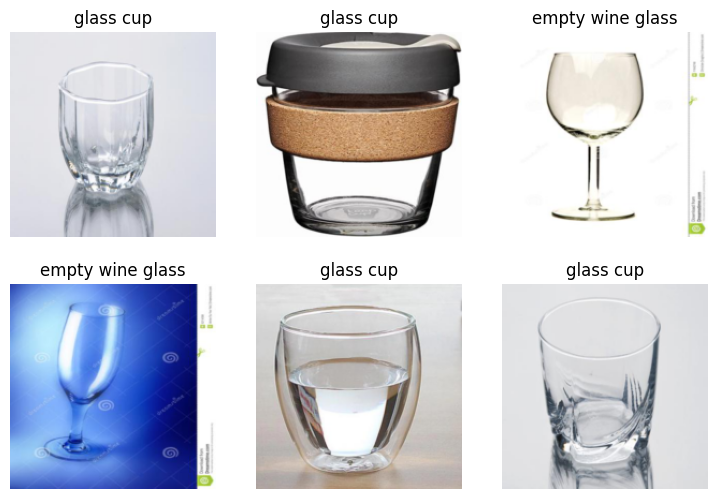

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now, we gonna train different resnet models and then compare each one.

#### 3.1. Resnet50

In [15]:
learn50 = vision_learner(dls, resnet50, metrics=error_rate)
learn50.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.654829,0.219910,0.078947,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.195066,0.195636,0.026316,01:22
1,0.118248,0.261332,0.078947,01:18
2,0.091215,0.364401,0.078947,01:25
3,0.078763,0.327096,0.078947,01:15


We can check out how many images our models has labeled correctly and the ones of highest loss.

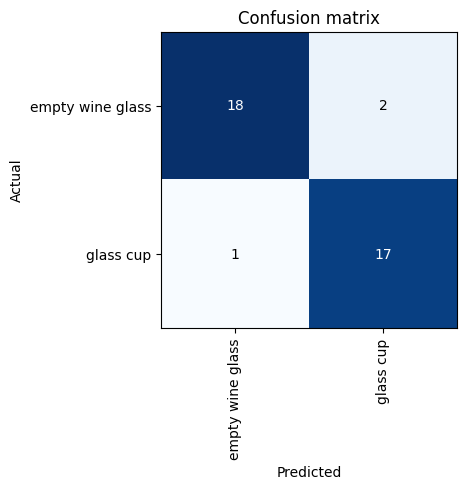

In [50]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_confusion_matrix()

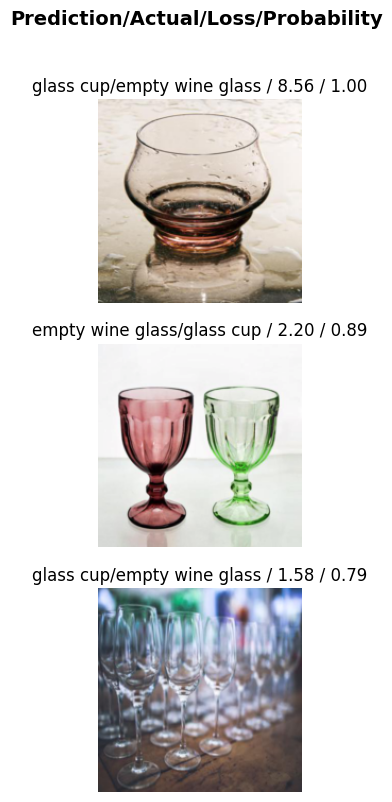

In [61]:
interp50.plot_top_losses(3, nrows=3)

Perhaps, resnet50 has mislabeled some dataset validation images because they're not very clear (shape, color).

#### 3.2. Resnet34

In [23]:
learn34 = vision_learner(dls, resnet34, metrics=error_rate)
learn34.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 130MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.444713,0.138679,0.052632,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.355716,0.091286,0.026316,01:00
1,0.260286,0.072855,0.052632,00:58
2,0.184009,0.080766,0.026316,00:54
3,0.136040,0.079578,0.026316,00:52


We can check out how many images our models has labeled correctly.

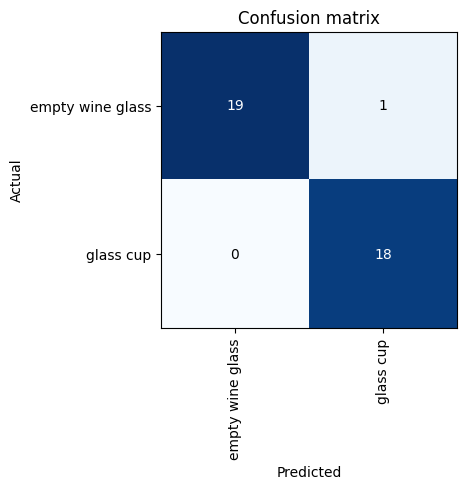

In [51]:
interp34 = ClassificationInterpretation.from_learner(learn34)
interp34.plot_confusion_matrix()

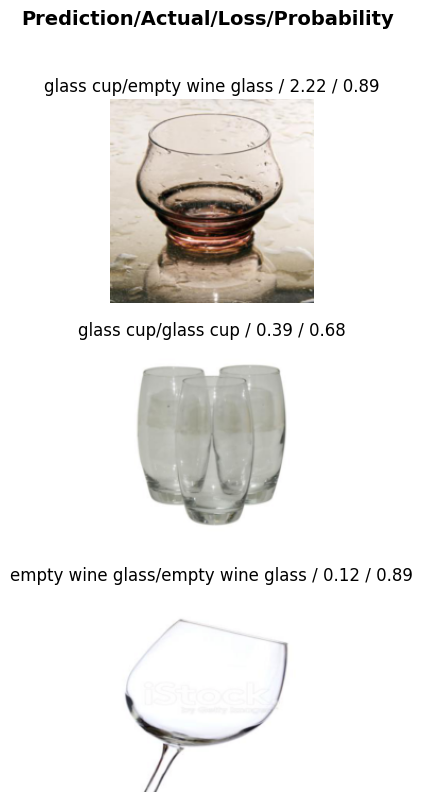

In [55]:
interp34.plot_top_losses(3, nrows=3)

#### 3.3. Resnet18

In [10]:
learn18 = vision_learner(dls, resnet18, metrics=error_rate)
learn18.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.176170,0.255284,0.052632,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.374165,0.219493,0.052632,00:32
1,0.228736,0.259386,0.052632,00:30
2,0.158767,0.241784,0.026316,00:29
3,0.116143,0.250334,0.026316,00:30


We can check out how many images our models has labeled correctly.

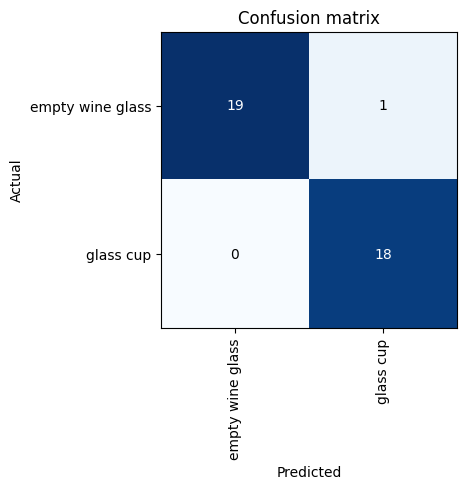

In [52]:
interp18 = ClassificationInterpretation.from_learner(learn18)
interp18.plot_confusion_matrix()

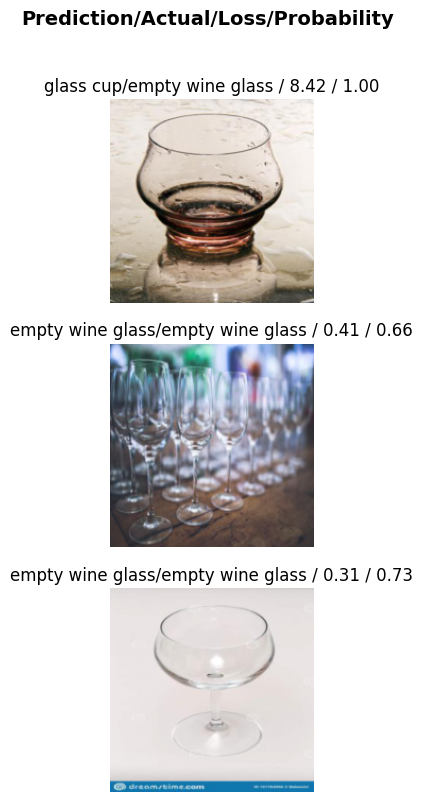

In [56]:
interp18.plot_top_losses(3, nrows=3)

#### 3.4. Comparison

Each resnet model has taken more time than others (resnet50 > resnet34 > resnet18), as expected. However, resnet18 and resnet34 have got a lower loss rate than resnet50.

## 4. Inference

#### 4.1. Glass cup

Let's use resnet18 and resnet34, those ones which had the best perfomance.

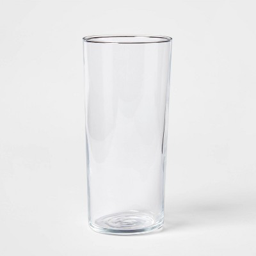

In [30]:
Image.open('testing/copo.jpeg').to_thumb(256, 256)

In [35]:
category,_,probs = learn34.predict(PILImage.create('testing/copo.jpeg'))
print(f"According to resnet34, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet34, this is a: glass cup.
Probability it's an wine glass: 0.0003641603
Probability it's a glass cup: 0.9996358156


In [37]:
category,_,probs = learn18.predict(PILImage.create('testing/copo.jpeg'))
print(f"According to resnet18, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet18, this is a: glass cup.
Probability it's an wine glass: 0.0007108735
Probability it's a glass cup: 0.9992891550


Ok, it worked as spected. Now let's try a image of a wine glass got from google images:

#### 4.2. Wine glass

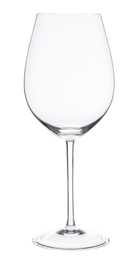

In [38]:
Image.open('testing/taca.jpg').to_thumb(256, 256)

In [39]:
category,_,probs = learn34.predict(PILImage.create('testing/taca.jpg'))
print(f"According to resnet34, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet34, this is a: empty wine glass.
Probability it's an wine glass: 0.9999716282
Probability it's a glass cup: 0.0000284189


In [40]:
category,_,probs = learn18.predict(PILImage.create('testing/taca.jpg'))
print(f"According to resnet18, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet18, this is a: empty wine glass.
Probability it's an wine glass: 0.9999907017
Probability it's a glass cup: 0.0000093332


It worked, as well. Now we gonna test some random image of a glass object.

#### 4.3. Random glass object

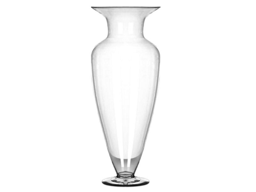

In [41]:
Image.open('testing/vaso.jpg').to_thumb(256, 256)

In [42]:
category,_,probs = learn34.predict(PILImage.create('testing/vaso.jpg'))
print(f"According to resnet34, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet34, this is a: glass cup.
Probability it's an wine glass: 0.1676138937
Probability it's a glass cup: 0.8323860765


In [44]:
category,_,probs = learn18.predict(PILImage.create('testing/vaso.jpg'))
print(f"According to resnet18, this is a: {category}.")
print(f"Probability it's an wine glass: {probs[0]:.10f}")
print(f"Probability it's a glass cup: {probs[1]:.10f}")

According to resnet18, this is a: glass cup.
Probability it's an wine glass: 0.0038911689
Probability it's a glass cup: 0.9961088300


## 5. Deployment

Exporting the model:

In [46]:
learn34.export("model.pkl")

You can check out the deployment of my resnet 34 [here](https://huggingface.co/spaces/brunomartins/lesson3).

## 6. Bibliographic Reference

[Jeremy Howard and Sylvain Gugge - FastBook](https://github.com/fastai/fastbook)

[How does a neural net really work? - Jeremy Howard](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)

[Which image models are the best? - Jeremy Howard](https://www.kaggle.com/code/jhoward/which-image-models-are-best/)